In [64]:
#import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
%matplotlib inline

In [5]:
import lightkurve as lk
lightcurve = lk.search_lightcurve("246.0684208 -32.2037824", mission="TESS").download_all()


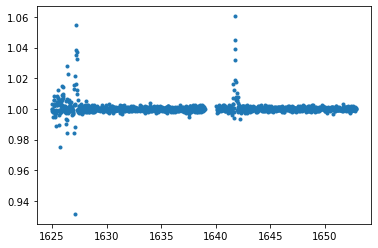

In [103]:
plt.plot(lightcurve.data[-1]['time'].value, lightcurve.data[-1]['flux'].value, '.')

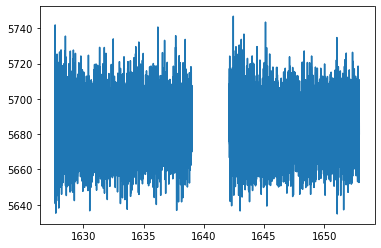

In [18]:
#lightcurve[0].fold(period=11.184).plot()
plt.plot(lightcurve.data[0]['time'].value, lightcurve.data[0]['flux'].value)

In [69]:
#

In [72]:
lightcurve[-1].flux=lightcurve[-1].flux.value*u.electron/u.s
lightcurve[-1].flux_err=lightcurve[-1].flux_err.value*u.electron/u.s

In [74]:
#lightcurve[-1]

In [75]:
from lightkurve.correctors import CBVCorrector
cbvCorrector = CBVCorrector(lightcurve[-1])

/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/designmatrix.py:307: LightkurveWarning: The design matrix has low rank (0) compared to the number of columns (8), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/designmatrix.py:307: LightkurveWarning: The design matrix has low rank (0) compared to the number of columns (8), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/lightcurve.py:965: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second tim

TimeoutError: Timeout limit of 600 exceeded.

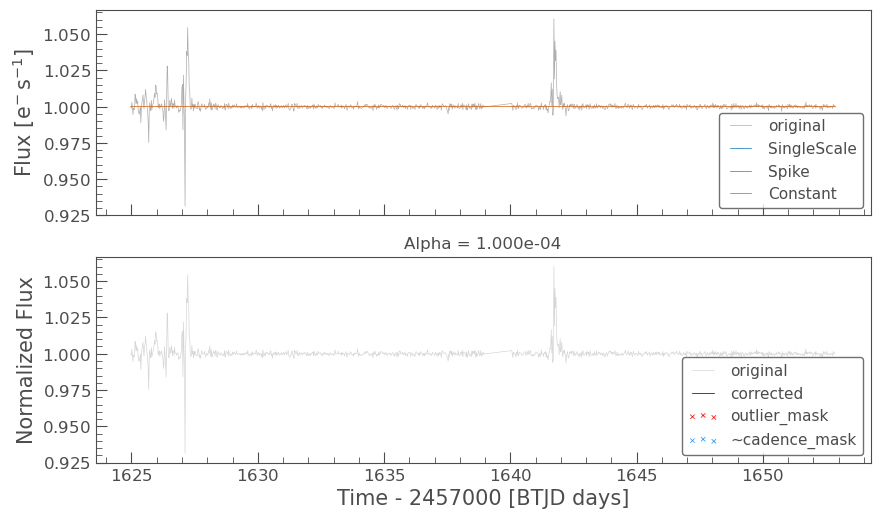

In [76]:
cbv_type = ['SingleScale', 'Spike']
# Select which CBV indices to use
# Use the first 8 SingleScale and all Spike CBVS
cbv_indices = [np.arange(1,9), 'ALL']
# Perform the correction
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)
cbvCorrector.diagnose();
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

LightCurveCollection of 2 objects:
	TIC 210904991 (2 TessLightCurves) Sectors: 12,12

In [94]:
#t=cbvCorrector.corrected_lc['time'].value
#flx=cbvCorrector.corrected_lc['flux'].value
#dflx=cbvCorrector.corrected_lc['flux_err'].value

t=lightcurve.data[-1]['time'].value
flx=lightcurve.data[-1]['flux'].value
dflx=lightcurve.data[-1]['flux_err'].value

In [93]:
#

In [95]:
flx

array([1.0001045 , 0.99879736, 1.0030843 , ..., 1.0006642 , 0.99993503,
       0.9997444 ], dtype=float32)

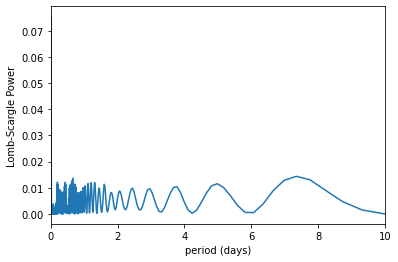

In [100]:
#lombscale from jakevdp blog
# Perform the correction
from gatspy.periodic import LombScargleFast
model = LombScargleFast().fit(t, flx, dflx)
periods, power = model.periodogram_auto(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0.0, 10),
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power');


In [101]:
# set range and find period
model.optimizer.period_range=(0.1, 5)
period = model.best_period
print("period = {0}".format(period))



Finding optimal frequency:
 - Estimated peak width = 0.225
 - Using 5 steps per peak; omega_step = 0.045
 - User-specified period range:  0.1 to 5
 - Computing periods at 1368 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 0.6612365564209763


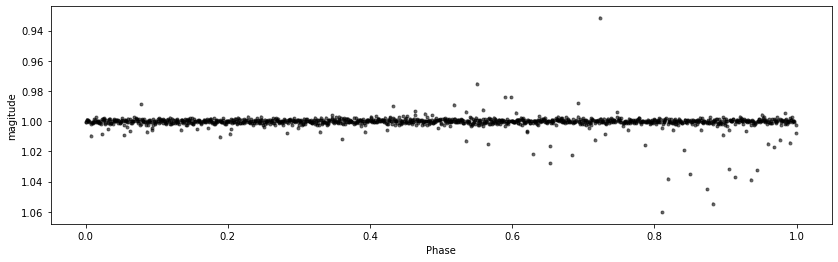

In [102]:
phase = (t / period) % 1

# Compute best-fit RR Lyrae template
#from gatspy.periodic import RRLyraeTemplateModeler
#model = RRLyraeTemplateModeler('r').fit(t, flx, dflx)
phase_fit = np.linspace(0, 1, 1000)
mag_fit = model.predict(period * phase_fit, period=period)

# Plot the phased data & model
fig, ax = plt.subplots(figsize=(14, 4))
ax.errorbar(phase, flx, dflx, fmt='.k', ecolor='gray', alpha=0.5)
#ax.plot(phase_fit, mag_fit, '-k')
ax.set(xlabel='Phase', ylabel='magitude')
ax.invert_yaxis();